In [3]:
#| tabs: [parameters]

FDR <- 0.1


In [2]:
setwd("/project/yangili1/cdai/splice-pub/analysis")


In [115]:
#| label: setup
#| include: false

library(tidyverse)
library(data.table)
library(glue)

library(cowplot)


library(GenomicRanges)
library(bedtoolsr)


In [243]:
multiqq <- function(pvalues) {
  library(foreach)
  if (is.null(names(pvalues))) {
    names(pvalues) <- seq_along(pvalues)
  }
  punif <- -log10(runif(max(sapply(pvalues, length))))
  df <- do.call(rbind, foreach(i = seq_len(length(pvalues))) %do% {
    df <- as.data.frame(
      qqplot(
        x = punif[1:length(pvalues[[i]])],
        y = -log10(pvalues[[i]]),
        plot.it = FALSE
      )
    )
    df$group <- names(pvalues)[i]
    df
  })

  df$group <- factor(df$group, names(pvalues))
  ggplot(df, aes(x, y, col = group)) +
    geom_point() +
    geom_abline(
      intercept = 0,
      slope = 1
    ) +
    xlab("Expected -log10(p)") +
    ylab("Observed -log10(p)")
}


In [5]:
addLabels <- function(dt) {
  pid_split <- str_split(dt$phenotype_id, ":")
  dt$itype <- map_chr(pid_split, ~ .x[5])
  dt$clu <- map_chr(pid_split, ~ .x[4])
  dt$clu <- str_extract(dt$clu, "clu_[0-9]+")

  dt <- dt[, ctype := paste(sort(unique(itype)), collapse = ","), by = clu][]
  return(dt)
}


In [82]:
tissue <- "Liver"


In [83]:
tissue


[1] "Liver"

In [84]:
readGTExSQTL <- function(tissue) {
  base1.gtex <- "../code/results/qtl/noisy/GTEx/"
  base2.gtex <- "/cis_100000/perm"
  suffix <- "addQval.txt.gz"
  folder <- glue("{base1.gtex}/{tissue}/separateNoise{base2.gtex}")
  files <- glue("{folder}/chr{1:22}.{suffix}")
  dt <- map_dfr(files, fread)
}


In [85]:
permDF <- readGTExSQTL(tissue) %>%
  addLabels()


In [86]:
permDF[1:5]
permDF %>% dim()


phenotype_id,phenotype_chr,phenotype_start,phenotype_end,phenotype_strand,num_variants,best_nom_dist,best_genotype_id,best_genotype_chr,best_genotype_start,⋯,beta_ml2,pval_nom,pval_r2,slope,pval_emp,pval_adj,q,itype,clu,ctype
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1:259025:261549:clu_1798_-:IN,chr1,259026,261549,-,5,-20363,chr1_281912_C_G_b38,chr1,281912,⋯,5.06287,0.103199,0.012838400,0.2326170,0.424575,0.424734,0.84636,IN,clu_1798,IN
chr1:259025:267302:clu_1798_-:IN,chr1,259026,267302,-,5,77361,chr1_181665_A_ATC_b38,chr1,181665,⋯,4.52409,0.290122,0.005430690,-0.2367420,0.825175,0.825387,0.94218,IN,clu_1798,IN
chr1:261634:267302:clu_1798_-:IN,chr1,261635,267302,-,5,-14610,chr1_281912_C_G_b38,chr1,281912,⋯,4.49487,0.677690,0.000840215,0.0575004,0.995005,0.994462,0.95695,IN,clu_1798,IN
chr1:497299:498072:clu_1800_-:IN,chr1,497300,498072,-,2,-93388,chr1_591460_T_C_b38,chr1,591460,⋯,1.95112,0.190496,0.008304830,-0.2691840,0.348651,0.331589,0.79810,IN,clu_1800,IN
chr1:497299:498398:clu_1800_-:IN,chr1,497300,498398,-,2,-4255,chr1_502653_G_T_b38,chr1,502653,⋯,1.98807,0.108353,0.012467000,0.3292840,0.217782,0.218448,0.74131,IN,clu_1800,IN


[1] 76805    24

In [87]:
readGTExNOM <- function(tissue) {
  base1.gtex <- "../code/results/eqtl/GTEx"
  paths <- glue("{base1.gtex}/{tissue}/nom/chr{1:22}.txt.gz")
  df <- map_dfr(paths, fread)
  names(df) <- c(
    "pid", "pchr", "pstart", "pend", "pstrand", "nVar", "dist",
    "vid", "vchr", "vstart", "vend", "pval", "r2", "slope", "topflag"
  )
  return(df)
}


In [88]:
nomDF <- readGTExNOM(tissue)


In [89]:
nomDF[1:5]
nomDF %>% dim()


pid,pchr,pstart,pend,pstrand,nVar,dist,vid,vchr,vstart,vend,pval,r2,slope,topflag
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
ENSG00000131591.17,chr1,1081818,1116361,-,217,900153,chr1_181665_A_ATC_b38,chr1,181665,181665,0.0147302,0.02853110,-0.1782600,0
ENSG00000188290.11,chr1,998962,1000172,-,212,817297,chr1_181665_A_ATC_b38,chr1,181665,181665,0.2356550,0.00682040,-0.1293600,0
ENSG00000187583.11,chr1,966482,975865,+,211,-784817,chr1_181665_A_ATC_b38,chr1,181665,181665,0.5029720,0.00218087,-0.0784723,0
ENSG00000188976.11,chr1,944203,959309,-,211,762538,chr1_181665_A_ATC_b38,chr1,181665,181665,0.6250190,0.00116173,-0.0396061,0
ENSG00000187961.14,chr1,960584,965719,+,211,-778919,chr1_181665_A_ATC_b38,chr1,181665,181665,0.0737227,0.01544210,-0.1322110,0


[1] 1446313      15

# first determine p-sQTLs and u-sQTLs, select only 1 per cluster


In [90]:
sqtl <- permDF[q < FDR & itype %in% c("PR", "UP") & ctype %in% c("PR", "PR,UP")]


In [101]:
# select the best intron per cluster based on the largest effect size
sqtl <- sqtl[, rk := frank(-abs(slope), ties.method = "first"), by = .(clu)][rk == 1]


In [103]:
sqtl[1:5]
sqtl %>% dim()


phenotype_id,phenotype_chr,phenotype_start,phenotype_end,phenotype_strand,num_variants,best_nom_dist,best_genotype_id,best_genotype_chr,best_genotype_start,⋯,pval_r2,slope,pval_emp,pval_adj,q,itype,clu,ctype,qtl_type,rk
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
chr1:941306:942135:clu_8_+:PR,chr1,941307,942135,+,558,58596,chr1_1000731_C_T_b38,chr1,1000731,⋯,0.0905641,0.410522,0.002997000,3.12738e-03,0.05669000,PR,clu_8,PR,p-sQTL,1
chr1:1082987:1084352:clu_1808_-:PR,chr1,1082988,1084352,-,596,3532,chr1_1079456_A_G_b38,chr1,1079456,⋯,0.1161460,-0.362335,0.000999001,1.95822e-04,0.00517610,PR,clu_1808,"PR,UP",u-sQTL,1
chr1:1090428:1091471:clu_1810_-:PR,chr1,1090429,1091471,-,604,0,chr1_1091327_C_A_b38,chr1,1091327,⋯,0.1350960,-0.444126,0.000999001,2.10856e-05,0.00068731,PR,clu_1810,PR,p-sQTL,1
chr1:1217804:1218457:clu_1814_-:PR,chr1,1217805,1218457,-,594,72,chr1_1217733_G_A_b38,chr1,1217733,⋯,0.1114230,-0.615276,0.000999001,2.18888e-04,0.00572330,PR,clu_1814,PR,p-sQTL,1
chr1:1389047:1390229:clu_1835_-:UP,chr1,1389048,1390229,-,467,-63641,chr1_1453870_A_C_b38,chr1,1453870,⋯,0.0878077,-0.568726,0.002997000,2.37384e-03,0.04552800,UP,clu_1835,"PR,UP",u-sQTL,1


[1] 2320   26

In [179]:
sqtl[1:5]


phenotype_id,phenotype_chr,phenotype_start,phenotype_end,phenotype_strand,num_variants,best_nom_dist,best_genotype_id,best_genotype_chr,best_genotype_start,⋯,pval_r2,slope,pval_emp,pval_adj,q,itype,clu,ctype,qtl_type,rk
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
chr1:941306:942135:clu_8_+:PR,chr1,941307,942135,+,558,58596,chr1_1000731_C_T_b38,chr1,1000731,⋯,0.0905641,0.410522,0.002997000,3.12738e-03,0.05669000,PR,clu_8,PR,p-sQTL,1
chr1:1082987:1084352:clu_1808_-:PR,chr1,1082988,1084352,-,596,3532,chr1_1079456_A_G_b38,chr1,1079456,⋯,0.1161460,-0.362335,0.000999001,1.95822e-04,0.00517610,PR,clu_1808,"PR,UP",u-sQTL,1
chr1:1090428:1091471:clu_1810_-:PR,chr1,1090429,1091471,-,604,0,chr1_1091327_C_A_b38,chr1,1091327,⋯,0.1350960,-0.444126,0.000999001,2.10856e-05,0.00068731,PR,clu_1810,PR,p-sQTL,1
chr1:1217804:1218457:clu_1814_-:PR,chr1,1217805,1218457,-,594,72,chr1_1217733_G_A_b38,chr1,1217733,⋯,0.1114230,-0.615276,0.000999001,2.18888e-04,0.00572330,PR,clu_1814,PR,p-sQTL,1
chr1:1389047:1390229:clu_1835_-:UP,chr1,1389048,1390229,-,467,-63641,chr1_1453870_A_C_b38,chr1,1453870,⋯,0.0878077,-0.568726,0.002997000,2.37384e-03,0.04552800,UP,clu_1835,"PR,UP",u-sQTL,1


In [106]:
sqtl.v <- sqtl[, best_genotype_id] %>% unique()


In [108]:
length(sqtl.v)
sqtl.v[1:5]


[1] 2295

[1] "chr1_1000731_C_T_b38" "chr1_1079456_A_G_b38" "chr1_1091327_C_A_b38"
[4] "chr1_1217733_G_A_b38" "chr1_1453870_A_C_b38"

# select only snps that are top sQTLs from nominal file


In [111]:
nomDF <- nomDF[vid %in% sqtl.v]


In [180]:
nomDF[1:5, ]


pid,pchr,pstart,pend,pstrand,nVar,dist,vid,vchr,vstart,vend,pval,r2,slope,topflag
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
ENSG00000188290.11,chr1,998962,1000172,-,212,-559,chr1_1000731_C_T_b38,chr1,1000731,1000731,0.021575,0.02536470,-0.1053300,0
ENSG00000187961.14,chr1,960584,965719,+,211,35012,chr1_1000731_C_T_b38,chr1,1000731,1000731,0.267520,0.00596469,0.0346937,0
ENSG00000188157.15,chr1,1020120,1056118,+,215,-19389,chr1_1000731_C_T_b38,chr1,1000731,1000731,0.035142,0.02136570,0.1183030,0
ENSG00000179403.12,chr1,1434861,1442882,+,263,-434130,chr1_1000731_C_T_b38,chr1,1000731,1000731,0.411580,0.00327555,0.0305357,0
ENSG00000197785.14,chr1,1512162,1534685,+,272,-511431,chr1_1000731_C_T_b38,chr1,1000731,1000731,0.427130,0.00306397,-0.0366804,0


# join the top SQTLs and eQTL nominal


In [201]:
mergeDF <- inner_join(sqtl[, .(phenotype_id, phenotype_chr, phenotype_start, phenotype_end, phenotype_strand, best_genotype_id, best_nom_dist, pval_nom, slope, itype, ctype)],
  nomDF[, .(pid, pchr, pstart, pend, pstrand, vid, dist, pval, slope, topflag)],
  by = c("best_genotype_id" = "vid"),
  suffix = c("_sqtl", "_eqtl"),
  relationship = "many-to-many"
)


In [202]:
# a eQTL (gene) must encompass the sQTL (intron)
# thus, the start and end of the eQTL must be within the start and end of the sQTL
# the strand must be the same, and the chromosome must be the same

mergeDF <- mergeDF[phenotype_chr == pchr & phenotype_strand == pstrand]
mergeDF <- mergeDF[phenotype_start >= pstart & phenotype_end <= pend]


In [203]:
dim(sqtl)


[1] 2320   26

In [204]:
mergeDF[1:3]
mergeDF %>% dim()


phenotype_id,phenotype_chr,phenotype_start,phenotype_end,phenotype_strand,best_genotype_id,best_nom_dist,pval_nom,slope_sqtl,itype,ctype,pid,pchr,pstart,pend,pstrand,dist,pval,slope_eqtl,topflag
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<int>
chr1:1082987:1084352:clu_1808_-:PR,chr1,1082988,1084352,-,chr1_1079456_A_G_b38,3532,4.72618e-07,-0.362335,PR,"PR,UP",ENSG00000131591.17,chr1,1081818,1116361,-,2362,0.010969000,0.0819196,0
chr1:1090428:1091471:clu_1810_-:PR,chr1,1090429,1091471,-,chr1_1091327_C_A_b38,0,4.72455e-08,-0.444126,PR,PR,ENSG00000131591.17,chr1,1081818,1116361,-,0,0.000171671,0.1175260,1
chr1:1217804:1218457:clu_1814_-:PR,chr1,1217805,1218457,-,chr1_1217733_G_A_b38,72,8.34233e-07,-0.615276,PR,PR,ENSG00000078808.18,chr1,1216908,1232067,-,0,0.035935800,0.1984900,0


[1] 2166   20

In [266]:
plotDF <- mergeDF[, .(
  gid = best_genotype_id,
  intron_id = phenotype_id,
  gene_id = pid,
  pval_sqtl = pval_nom,
  pval_eqtl = pval,
  slope_sqtl,
  slope_eqtl,
  ctype,
  topflag
)]


In [267]:
dim(plotDF)
plotDF[1:5]
unique(plotDF) %>% dim()


[1] 2166    9

gid,intron_id,gene_id,pval_sqtl,pval_eqtl,slope_sqtl,slope_eqtl,ctype,topflag
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
chr1_1079456_A_G_b38,chr1:1082987:1084352:clu_1808_-:PR,ENSG00000131591.17,4.72618e-07,0.010969000,-0.362335,0.0819196,"PR,UP",0
chr1_1091327_C_A_b38,chr1:1090428:1091471:clu_1810_-:PR,ENSG00000131591.17,4.72455e-08,0.000171671,-0.444126,0.1175260,PR,1
chr1_1217733_G_A_b38,chr1:1217804:1218457:clu_1814_-:PR,ENSG00000078808.18,8.34233e-07,0.035935800,-0.615276,0.1984900,PR,0
chr1_1453870_A_C_b38,chr1:1389047:1390229:clu_1835_-:UP,ENSG00000221978.12,1.38712e-05,0.275098000,-0.568726,0.0444945,"PR,UP",0
chr1_1609890_C_T_b38,chr1:1642001:1642346:clu_1843_-:PR,ENSG00000248333.8,1.90325e-06,0.049742600,-0.540764,0.1371800,PR,0


[1] 2166    9

In [277]:
qqplot <- list(
  Productive = plotDF[ctype == "PR", pval_eqtl],
  Unproductive = plotDF[ctype == "PR,UP", pval_eqtl]
) %>%
  multiqq()


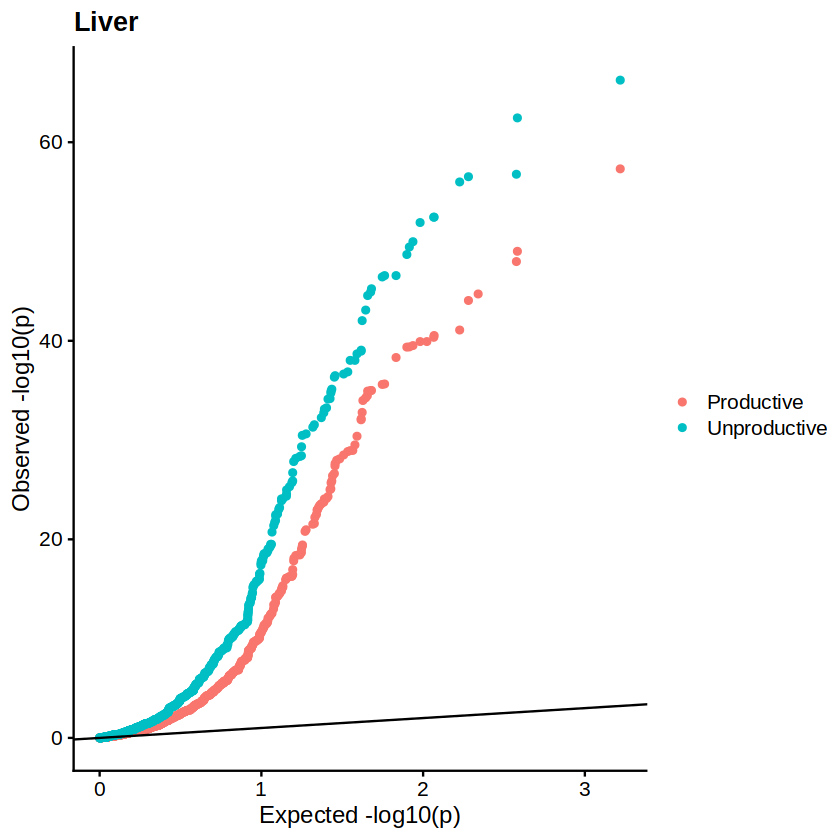

In [284]:
Title <- glue("{tissue}")

qqplot + theme_cowplot() +
  labs(title = Title) +
  theme(legend.title = element_blank())


In [ ]:
dim(plotDF)
plotDF[1:5]
unique(plotDF) %>% dim()


[1] 2166    9

gid,intron_id,gene_id,pval_sqtl,pval_eqtl,slope_sqtl,slope_eqtl,ctype,topflag
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
chr1_1079456_A_G_b38,chr1:1082987:1084352:clu_1808_-:PR,ENSG00000131591.17,4.72618e-07,0.010969000,-0.362335,0.0819196,"PR,UP",0
chr1_1091327_C_A_b38,chr1:1090428:1091471:clu_1810_-:PR,ENSG00000131591.17,4.72455e-08,0.000171671,-0.444126,0.1175260,PR,1
chr1_1217733_G_A_b38,chr1:1217804:1218457:clu_1814_-:PR,ENSG00000078808.18,8.34233e-07,0.035935800,-0.615276,0.1984900,PR,0
chr1_1453870_A_C_b38,chr1:1389047:1390229:clu_1835_-:UP,ENSG00000221978.12,1.38712e-05,0.275098000,-0.568726,0.0444945,"PR,UP",0
chr1_1609890_C_T_b38,chr1:1642001:1642346:clu_1843_-:PR,ENSG00000248333.8,1.90325e-06,0.049742600,-0.540764,0.1371800,PR,0


[1] 2166    9

In [301]:
corr <- plotDF[, .(slope_sqtl, slope_eqtl, ctype = if_else(ctype == "PR", "PR", "UP"))]  %>% 
  split( by = "ctype")  %>% 
  map(~cor.test(x = .x$slope_eqtl, y = .x$slope_sqtl, method = "s"))

Warning message in cor.test.default(x = .x$slope_eqtl, y = .x$slope_sqtl, method = "s"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = .x$slope_eqtl, y = .x$slope_sqtl, method = "s"):
“Cannot compute exact p-value with ties”


In [300]:
corr$UP$p.value

[1] 0.0001481149

In [302]:
corr

$UP

	Spearman's rank correlation rho

data:  .x$slope_eqtl and .x$slope_sqtl
S = 156006739, p-value = 0.0001481
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.1233788 


$PR

	Spearman's rank correlation rho

data:  .x$slope_eqtl and .x$slope_sqtl
S = 327026633, p-value = 0.01831
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.06739803 



In [310]:
corr$PR


	Spearman's rank correlation rho

data:  .x$slope_eqtl and .x$slope_sqtl
S = 327026633, p-value = 0.01831
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.06739803 


In [316]:
library(ggpointdensity)

In [390]:

corr <- plotDF[, .(slope_sqtl, slope_eqtl, ctype = if_else(ctype == "PR", "PR", "UP"))]  %>% 
  split( by = "ctype")  %>% 
  map(~cor.test(x = .x$slope_eqtl, y = .x$slope_sqtl, method = "p"))

corr.pvals <- map(corr, ~.x$p.value) %>% unlist
corr.estimates <- map(corr, ~.x$estimate[[1]]) %>% unlist

if (all(names(corr.pvals) == names(corr.estimates))) {
  corr.df <- data.frame(
    ctype = if_else(names(corr.pvals) == "PR", "Productive", "Unproductive"),
    pval = corr.pvals,
    estimate = corr.estimates
  )
} else {
  stop("names of pvals and estimates do not match")
}



In [391]:
corr.df <- corr.df %>% 
  mutate(xpos = c(0,0), ypos = c(0,0))
corr.df

,ctype,pval,estimate,xpos,ypos
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
UP,Unproductive,1.988646e-08,-0.18169452,0,0
PR,Productive,1.563543e-02,-0.06905422,0,0


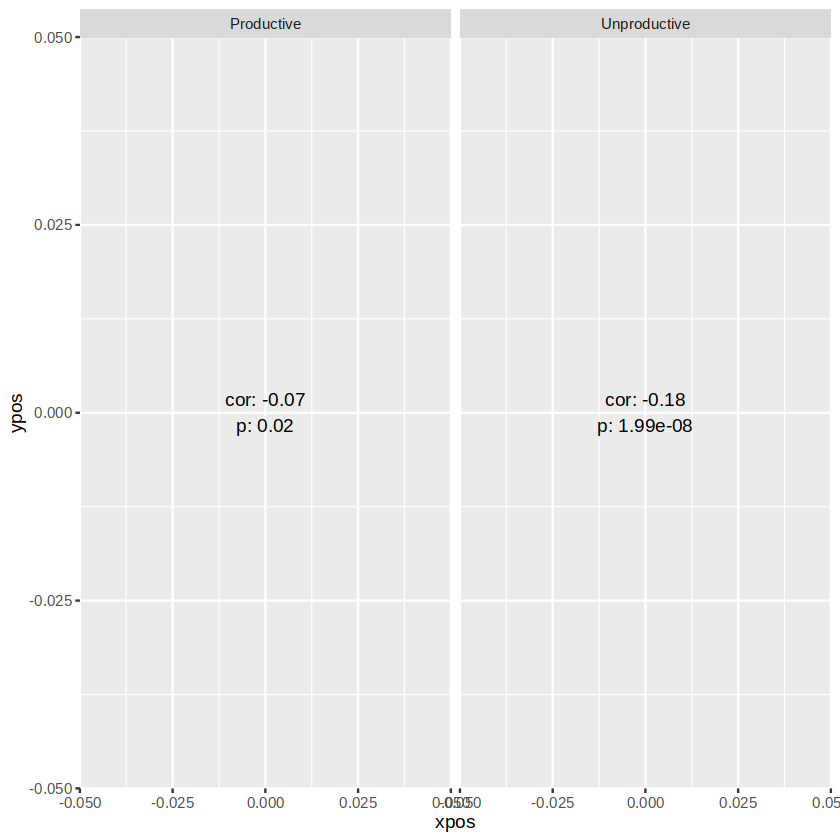

In [387]:
ggplot(corr.df) + 
  geom_text(aes(x = xpos, y = ypos, 
                label = glue("cor: {corr}\np: {pvalue}", 
                              corr = if_else(abs(estimate) > .001, scales::number(estimate, .01), scales::scientific(estimate)),
                              pvalue = if_else(pval > .001, scales::number(pval, .01), scales::scientific(pval)),
                            )
                )
            ) +
  facet_wrap(~type)

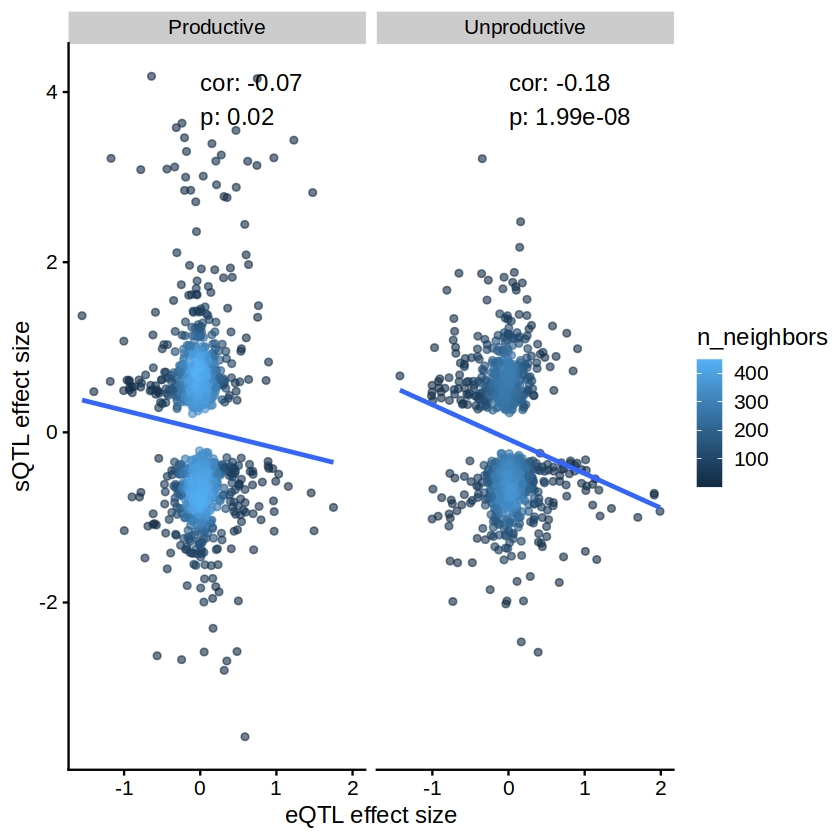

In [405]:
plotDF[, .(slope_sqtl, slope_eqtl, ctype)] %>% 
  mutate(ctype = if_else(ctype == "PR", "Productive", "Unproductive")) %>%
  ggplot() + geom_pointdensity(aes(slope_eqtl, slope_sqtl), alpha = .6) +
    geom_smooth(aes(slope_eqtl, slope_sqtl), method = "lm", se = F, formula = y~x) +
    geom_text(data = corr.df, mapping = aes(x = xpos, y = ypos, 
                label = glue("cor: {corr}\np: {pvalue}", 
                              corr = if_else(abs(estimate) > .001, scales::number(estimate, .01), scales::scientific(estimate)),
                              pvalue = if_else(pval > .001, scales::number(pval, .01), scales::scientific(pval)),
                            )
                ), size = 5, hjust = 0, vjust = -6
            ) +
    labs(x = "eQTL effect size", y = "sQTL effect size") +
    facet_wrap(~ctype) + theme_cowplot()

In [117]:
sqtl.gr <- sqtl[, .(phenotype_chr, phenotype_start, phenotype_end, phenotype_strand, phenotype_id)]
sqtl.gr <- makeGRangesFromDataFrame(sqtl.gr,
  keep.extra.columns = TRUE, seqnames.field = "phenotype_chr",
  start.field = "phenotype_start", end.field = "phenotype_end",
  strand.field = "phenotype_strand"
)


In [132]:
sqtl.gr %>% sort()


GRanges object with 2320 ranges and 1 metadata column:
         seqnames            ranges strand |           phenotype_id
            <Rle>         <IRanges>  <Rle> |            <character>
     [1]     chr1     941307-942135      + | chr1:941306:942135:c..
     [2]     chr1   2156093-2169517      + | chr1:2156092:2169517..
     [3]     chr1   6448562-6448640      + | chr1:6448561:6448640..
     [4]     chr1   6449092-6451602      + | chr1:6449091:6451602..
     [5]     chr1   6580050-6580540      + | chr1:6580049:6580540..
     ...      ...               ...    ... .                    ...
  [2316]    chr22 50284666-50285799      - | chr22:50284665:50285..
  [2317]    chr22 50526142-50526245      - | chr22:50526141:50526..
  [2318]    chr22 50571293-50571374      - | chr22:50571292:50571..
  [2319]    chr22 50571534-50572005      - | chr22:50571533:50572..
  [2320]    chr22 50782348-50783500      - | chr22:50782347:50783..
  -------
  seqinfo: 22 sequences from an unspecified genome;

In [121]:
nom.gr <- nomDF[, .(pid, pchr, pstart, pend, pstrand)] %>% unique()
nom.gr <- makeGRangesFromDataFrame(nom.gr,
  keep.extra.columns = TRUE, seqnames.field = "pchr",
  start.field = "pstart", end.field = "pend",
  strand.field = "pstrand"
)


In [124]:
sort(sqtl.gr)


GRanges object with 2320 ranges and 1 metadata column:
         seqnames            ranges strand |           phenotype_id
            <Rle>         <IRanges>  <Rle> |            <character>
     [1]     chr1     941307-942135      + | chr1:941306:942135:c..
     [2]     chr1   2156093-2169517      + | chr1:2156092:2169517..
     [3]     chr1   6448562-6448640      + | chr1:6448561:6448640..
     [4]     chr1   6449092-6451602      + | chr1:6449091:6451602..
     [5]     chr1   6580050-6580540      + | chr1:6580049:6580540..
     ...      ...               ...    ... .                    ...
  [2316]    chr22 50284666-50285799      - | chr22:50284665:50285..
  [2317]    chr22 50526142-50526245      - | chr22:50526141:50526..
  [2318]    chr22 50571293-50571374      - | chr22:50571292:50571..
  [2319]    chr22 50571534-50572005      - | chr22:50571533:50572..
  [2320]    chr22 50782348-50783500      - | chr22:50782347:50783..
  -------
  seqinfo: 22 sequences from an unspecified genome;

In [140]:
x <- GenomicRanges::distanceToNearest(sqtl.gr, nom.gr, select = "arbitrary", ignore.strand = TRUE)


In [141]:
x


Hits object with 2320 hits and 1 metadata column:
         queryHits subjectHits |  distance
         <integer>   <integer> | <integer>
     [1]         1          38 |      2067
     [2]         2          31 |         0
     [3]         3          31 |         0
     [4]         4          22 |         0
     [5]         5          15 |         0
     ...       ...         ... .       ...
  [2316]      2316       11556 |         0
  [2317]      2317       11563 |         0
  [2318]      2318       11558 |         0
  [2319]      2319       11558 |         0
  [2320]      2320       11560 |         0
  -------
  queryLength: 2320 / subjectLength: 11586

In [143]:
x$metada


ERROR: Error in x$metadata: $ operator not defined for this S4 class


In [98]:
sqtl[, .(Nclu = uniqueN(clu)), by = .(ctype)]
sqtl[, .(Nclu = uniqueN(clu)), by = .(qtl_type)]


ctype,Nclu
<chr>,<int>
PR,1313
"PR,UP",1007


qtl_type,Nclu
<chr>,<int>
p-sQTL,1313
u-sQTL,1007


In [95]:
sqtl[ctype == "PR,UP"][, .N, by = itype]


itype,N
<chr>,<int>
PR,1041
UP,870
